# Classification with Support Vector Machine

## Import libraries and data.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.svm import SVC

In [32]:
df = pd.read_csv("Train_prepd")

In [33]:
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
0,0.0,3.0,22.0,7.2500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,7.9250,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,3.0,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


dims:  (891, 13)


In [34]:
df.describe()

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.951235,32.204208,0.904602,0.647587,0.086420,0.722783,0.204265,0.580247,0.140292,0.030303,0.771044
std,0.486592,0.836071,14.176038,49.693429,1.613459,0.477990,0.281141,0.447876,0.403390,0.493796,0.347485,0.171516,0.420397
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,28.000000,14.454200,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,38.000000,31.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split dependent and independent variables

In [35]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Split into training and test set

The dataset is fairly imbalanced (38% survived), so we'll use stratification in the train/test split.

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 420)
X_train

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
814,3.0,30.500000,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
722,2.0,34.000000,13.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
247,2.0,24.000000,14.5000,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
683,3.0,14.000000,46.9000,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
657,3.0,32.000000,15.5000,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
153,3.0,40.500000,14.5000,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
155,1.0,51.000000,61.3792,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
129,3.0,45.000000,6.9750,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
713,3.0,29.000000,9.4833,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Feature scaling

Feature scaling is essential for Support Vector Machines. I will try a couple different methods. From data exploration we noticed that Age is not very far from being normally distributed. Fare is definitely not normally distributed (more like log-normal) and has extreme outliers.

### Standardize everything (incl. dummies)

In [37]:
standardizer1 = StandardScaler()
X_train_st_all = standardizer1.fit_transform(X_train)
X_test_st_all = standardizer1.transform(X_test)
pd.DataFrame(X_train_st_all)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.849453,0.014162,-0.506214,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
1,-0.334129,0.262530,-0.402018,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
2,-0.334129,-0.447094,-0.370444,0.674673,-1.351072,-0.303355,0.635877,-0.507888,-1.185498,2.459574,-0.178561,0.564374
3,0.849453,-1.156718,0.311567,3.726559,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
4,0.849453,0.120605,-0.349394,0.674673,-1.351072,3.296463,-1.572632,-0.507888,-1.185498,2.459574,-0.178561,0.564374
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.849453,0.723786,-0.370444,0.674673,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
708,-1.517711,1.468891,0.616350,0.064295,0.740153,-0.303355,-1.572632,-0.507888,0.843527,-0.406574,-0.178561,0.564374
709,0.849453,1.043117,-0.528843,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
710,0.849453,-0.092282,-0.476044,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374


### Normalize everything

In [38]:
normalizer1 = MinMaxScaler()
X_train_norm_all = normalizer1.fit_transform(X_train)
X_test_norm_all = normalizer1.transform(X_test)
pd.DataFrame(X_train_norm_all)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.377984,0.015713,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.5,0.421965,0.025374,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.5,0.296306,0.028302,0.2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.170646,0.091543,0.7,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.396833,0.030254,0.2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
707,1.0,0.503644,0.028302,0.2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
708,0.0,0.635587,0.119804,0.1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
709,1.0,0.560191,0.013614,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
710,1.0,0.359135,0.018510,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Standardize Numeric only

In [39]:
standardizer2 = StandardScaler()
X_train_st_some = X_train.copy()
X_train_st_some[['Age', 'Fare', 'FamSize', 'Pclass']] = standardizer2.fit_transform(X_train_st_some[['Age', 'Fare', 'FamSize', 'Pclass']])
X_test_st_some = X_test.copy()
X_test_st_some[['Age', 'Fare', 'FamSize', 'Pclass']] = standardizer2.transform(X_test_st_some[['Age', 'Fare', 'FamSize', 'Pclass']])
X_train_st_some

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
814,0.849453,0.014162,-0.506214,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
722,-0.334129,0.262530,-0.402018,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
247,-0.334129,-0.447094,-0.370444,0.674673,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
683,0.849453,-1.156718,0.311567,3.726559,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
657,0.849453,0.120605,-0.349394,0.674673,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.849453,0.723786,-0.370444,0.674673,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
155,-1.517711,1.468891,0.616350,0.064295,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
129,0.849453,1.043117,-0.528843,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
713,0.849453,-0.092282,-0.476044,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Mix of standardization and normalization

In [40]:
normalizer2 = MinMaxScaler()
standardizer3 = StandardScaler()

# Normalize 'Fare', as it does not follow a Gaussian distribution
# Standardize everything else except for dummies

X_train_fs = X_train.copy()
X_test_fs = X_test.copy()
X_train_fs[['Fare']] = normalizer2.fit_transform(X_train_fs[['Fare']])
X_test_fs[['Fare']] = normalizer2.transform(X_test_fs[['Fare']])
X_train_fs[['Pclass', 'Age', 'FamSize']] = standardizer3.fit_transform(X_train_fs[['Pclass', 'Age', 'FamSize']])
X_test_fs[['Pclass', 'Age', 'FamSize']] = standardizer3.transform(X_test_fs[['Pclass', 'Age', 'FamSize']])
display(X_train_fs)

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
814,0.849453,0.014162,0.015713,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
722,-0.334129,0.262530,0.025374,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
247,-0.334129,-0.447094,0.028302,0.674673,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
683,0.849453,-1.156718,0.091543,3.726559,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
657,0.849453,0.120605,0.030254,0.674673,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.849453,0.723786,0.028302,0.674673,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
155,-1.517711,1.468891,0.119804,0.064295,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
129,0.849453,1.043117,0.013614,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
713,0.849453,-0.092282,0.018510,-0.546082,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Preliminary model

Build the most basic SVC and get an initial feel about what we can do with SVM and which feature scaling approach will work best.

### Without feature scaling

In [41]:
#train
classifier = SVC(kernel = 'linear', random_state = 420)
classifier.fit(X_train, y_train)

#predict
y_pred = classifier.predict(X_test)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8156424581005587
[[96 14]
 [19 50]]


### With all features standardized

In [42]:
#train
classifier = SVC(kernel = 'linear', random_state = 420)
classifier.fit(X_train_st_all, y_train)

#predict
y_pred = classifier.predict(X_test_st_all)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.7932960893854749
[[92 18]
 [19 50]]


### With all features normalized

In [43]:
#train
classifier = SVC(kernel = 'linear', random_state = 420)
classifier.fit(X_train_norm_all, y_train)

#predict
y_pred = classifier.predict(X_test_norm_all)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8044692737430168
[[94 16]
 [19 50]]


### With only numeric features standardized

In [44]:
#train
classifier = SVC(kernel = 'linear', random_state = 420)
classifier.fit(X_train_st_some, y_train)

#predict
y_pred = classifier.predict(X_test_st_some)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8100558659217877
[[95 15]
 [19 50]]


### With mixed feature scaling

In [45]:
#train
classifier = SVC(kernel = 'linear', random_state = 420)
classifier.fit(X_train_fs, y_train)

#predict
y_pred = classifier.predict(X_test_fs)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8044692737430168
[[94 16]
 [19 50]]


On a simple train/test split, the best performing linear models are the one with only numeric features standardized (81%) and the one without feature scaling (81,5%)

We are going to use cross validation to get a better accuracy estimation, for different feature scaling techniques and different models/hyperparameters.

## Hyperparameter tuning

Here I'm using Grid Search 10-fold CV inside the X_train to find the best SVC hypermarameters. There is data leakage in the validation sets, which I'm ignoring here. I'm doing the CV for each feature scaling method to compare results.

In [46]:
parameters = [{'C': [0.25, 0.5, 0.75, 1, 10, 100], 
               'kernel': ['linear']
              },
              {'C': [0.25, 0.5, 0.75, 1, 10, 100], 
               'kernel': ['rbf'], 
               'gamma': ['scale', 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
              }]

gs = GridSearchCV(estimator=SVC(), param_grid=parameters, cv=10, scoring='accuracy')

### Standardized all

In [47]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_train_st_all, y_train)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 84.13 %
Best Parameters:  {'C': 0.5, 'gamma': 0.3, 'kernel': 'rbf'}
Time: 10.40


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
24,0.005705,0.000459,0.001701,0.000459,0.5,rbf,0.3,"{'C': 0.5, 'gamma': 0.3, 'kernel': 'rbf'}",0.861111,0.791667,...,0.788732,0.859155,0.788732,0.901408,0.845070,0.859155,0.84507,0.841334,0.036989,1
45,0.005505,0.000500,0.001301,0.000459,1,rbf,scale,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.847222,0.819444,...,0.774648,0.859155,0.788732,0.915493,0.830986,0.845070,0.84507,0.839906,0.038311,2
48,0.005505,0.000807,0.001301,0.000459,1,rbf,0.1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.833333,0.805556,...,0.774648,0.859155,0.788732,0.915493,0.830986,0.859155,0.84507,0.838537,0.039691,3


### Standardized some

In [48]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_train_st_some, y_train)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start))  

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.44 %
Best Parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Time: 10.38


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
73,0.010309,0.001488,0.001802,6.006241e-04,100,rbf,0.01,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.819444,0.777778,...,0.816901,0.859155,0.816901,0.915493,0.816901,0.830986,0.816901,0.834370,0.036556,1
32,0.006106,0.000300,0.002002,1.862109e-07,0.75,rbf,scale,"{'C': 0.75, 'gamma': 'scale', 'kernel': 'rbf'}",0.805556,0.763889,...,0.802817,0.859155,0.830986,0.901408,0.816901,0.830986,0.816901,0.831592,0.039067,2
35,0.005805,0.000601,0.002202,6.006003e-04,0.75,rbf,0.1,"{'C': 0.75, 'gamma': 0.1, 'kernel': 'rbf'}",0.805556,0.777778,...,0.816901,0.859155,0.830986,0.901408,0.816901,0.830986,0.802817,0.831573,0.034932,3


### Normalize all

In [49]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_train_norm_all, y_train)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 84.13 %
Best Parameters:  {'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}
Time: 6.81


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
57,0.005405,0.000664,0.001001,1.192093e-07,1,rbf,1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.833333,0.833333,...,0.788732,0.859155,0.788732,0.915493,0.816901,0.859155,0.830986,0.841315,0.038230,1
56,0.005205,0.000400,0.001101,3.001452e-04,1,rbf,0.9,"{'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}",0.833333,0.833333,...,0.788732,0.859155,0.788732,0.915493,0.816901,0.859155,0.830986,0.841315,0.038230,1
44,0.004804,0.000400,0.001201,4.002452e-04,0.75,rbf,1,"{'C': 0.75, 'gamma': 1, 'kernel': 'rbf'}",0.847222,0.833333,...,0.788732,0.859155,0.788732,0.915493,0.816901,0.859155,0.816901,0.841295,0.038828,3


### No feature scaling

In [50]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_train, y_train)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.01 %
Best Parameters:  {'C': 100, 'kernel': 'linear'}
Time: 589.38


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,36.932761,10.998855,0.001201,0.00040,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.805556,0.819444,...,0.816901,0.859155,0.830986,0.901408,0.816901,0.816901,0.774648,0.830106,0.033298,1
1,0.328098,0.151186,0.001401,0.00049,0.5,linear,NaN,"{'C': 0.5, 'kernel': 'linear'}",0.805556,0.791667,...,0.802817,0.859155,0.830986,0.887324,0.816901,0.816901,0.802817,0.825919,0.028435,2
2,0.473830,0.130767,0.001201,0.00040,0.75,linear,NaN,"{'C': 0.75, 'kernel': 'linear'}",0.805556,0.791667,...,0.802817,0.859155,0.830986,0.887324,0.816901,0.816901,0.802817,0.825919,0.028435,2


### Mixed feature scaling

In [51]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_train_fs, y_train)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.58 %
Best Parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Time: 10.53


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
73,0.008908,0.000944,0.001601,4.903102e-04,100,rbf,0.01,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.819444,0.791667,...,0.816901,0.859155,0.816901,0.915493,0.816901,0.830986,0.802817,0.835759,0.037348,1
61,0.008308,0.000901,0.002002,1.283923e-07,10,rbf,0.1,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.847222,0.819444,...,0.788732,0.830986,0.802817,0.887324,0.830986,0.859155,0.802817,0.835681,0.032696,2
35,0.005605,0.000490,0.001802,4.003644e-04,0.75,rbf,0.1,"{'C': 0.75, 'gamma': 0.1, 'kernel': 'rbf'}",0.819444,0.791667,...,0.816901,0.859155,0.830986,0.915493,0.816901,0.830986,0.788732,0.834351,0.036699,3


There are 2 models that tie for the best performing model (84.13%).

The SVM with an rbf kernel, some regularization (C = 0.5), and gamma = 0.3 on the fully standardized data, and
the SVM with an rbf kernel, C = 1, and gamma = 0.9, on the fully normalized data.

I will use the first one.

## Build and test the final model

Here:
1. Take the entire dataset, in its standardized version.
2. Build and test on a single train/test split.
3. 10-fold cross validation to get a more robust estimate of how this logistic regression model will perform.

As before, there is data leakage into the validation sets when I'm doing CV, which I'm ignoring for now. The proper way to do this would be, for each of the k train/validation splits in the CV to fit the scaler on the train split only, so as to not take into account the mean and st.dev of the validation set in the standardization. 


In [52]:
X_train

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
814,3.0,30.500000,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
722,2.0,34.000000,13.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
247,2.0,24.000000,14.5000,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
683,3.0,14.000000,46.9000,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
657,3.0,32.000000,15.5000,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
153,3.0,40.500000,14.5000,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
155,1.0,51.000000,61.3792,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
129,3.0,45.000000,6.9750,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
713,3.0,29.000000,9.4833,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [53]:
pd.DataFrame(X_train_st_all)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.849453,0.014162,-0.506214,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
1,-0.334129,0.262530,-0.402018,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
2,-0.334129,-0.447094,-0.370444,0.674673,-1.351072,-0.303355,0.635877,-0.507888,-1.185498,2.459574,-0.178561,0.564374
3,0.849453,-1.156718,0.311567,3.726559,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
4,0.849453,0.120605,-0.349394,0.674673,-1.351072,3.296463,-1.572632,-0.507888,-1.185498,2.459574,-0.178561,0.564374
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.849453,0.723786,-0.370444,0.674673,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
708,-1.517711,1.468891,0.616350,0.064295,0.740153,-0.303355,-1.572632,-0.507888,0.843527,-0.406574,-0.178561,0.564374
709,0.849453,1.043117,-0.528843,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374
710,0.849453,-0.092282,-0.476044,-0.546082,0.740153,-0.303355,0.635877,-0.507888,0.843527,-0.406574,-0.178561,0.564374


Fit the Support Vector Machine with rbf kernel and some regularization. Then predict for the test set.

Accuracy: 80.45 %


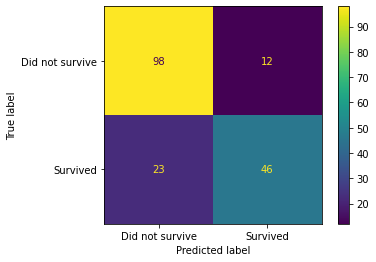

In [56]:
#train
classifier = SVC(kernel='rbf',gamma=0.3, C=0.5, random_state = 420)
classifier.fit(X_train_st_all, y_train)

#predict
y_pred = classifier.predict(X_test_st_all)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(classifier, 
                     X_test_st_all,
                     y_test, display_labels=['Did not survive', 'Survived'])

Check the model with linear kernel for reference

Accuracy: 79.33 %


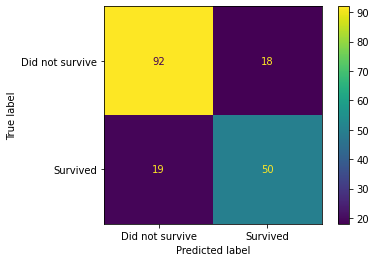

In [57]:
#train
classifier = SVC(kernel='linear', random_state = 420)
classifier.fit(X_train_st_all, y_train)

#predict
y_pred = classifier.predict(X_test_st_all)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(classifier, 
                     X_test_st_all,
                     y_test, display_labels=['Did not survive', 'Survived'])

Get a more accurate performance for the rbf model using 10-fold cross validation.

In [26]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [62]:
# create model
classifier = SVC(kernel='rbf',gamma=0.3, C=0.5, random_state = 420)

# evaluate with (stratified) 10-fold CV
scores = cross_val_score(classifier, X_sc, y, cv=10)

# print the results
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.2f}'.format(scores.std()))

scores:  [0.82222222 0.82022472 0.7752809  0.86516854 0.84269663 0.83146067
 0.80898876 0.79775281 0.86516854 0.85393258]
Accuracy: 82.83 %
St.dev: 0.03


Cross validated linear SVC model for reference.

In [63]:
# create model
classifier = SVC(kernel='linear', random_state = 420)

# evaluate with (stratified) 10-fold CV
scores = cross_val_score(classifier, X_sc, y, cv=10)

# print the results
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.2f}'.format(scores.std()))

scores:  [0.82222222 0.86516854 0.76404494 0.87640449 0.83146067 0.79775281
 0.80898876 0.79775281 0.87640449 0.85393258]
Accuracy: 82.94 %
St.dev: 0.04
